<a href="https://colab.research.google.com/github/saivardhan4694/cancer-app/blob/main/Breast_Cancer_Classification_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images/data")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: makkapatimrk
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images


100%|██████████| 3.10G/3.10G [00:27<00:00, 121MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from skimage.io import imread
import cv2

In [ ]:
images = glob.glob('/content/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)
images[0]

'/content/breast-histopathology-images/IDC_regular_ps50_idx5/15516/1/15516_idx5_x2501_y1901_class1.png'

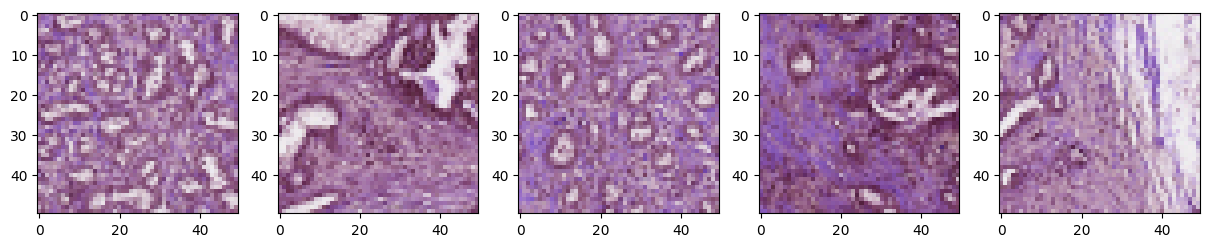

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img = cv2.imread(images[i])
    axes[i].imshow(img)

In [ ]:
df = pd.DataFrame(index=np.arange(0, len(images)), columns=["path", "target"])
for i in range(len(images)):
    df.loc[i, "path"] = images[i]
    df.loc[i, "target"] = int(images[i][-5])

In [ ]:
df

,path,target
0,/content/breast-histopathology-images/IDC_regu...,1
1,/content/breast-histopathology-images/IDC_regu...,1
2,/content/breast-histopathology-images/IDC_regu...,1
3,/content/breast-histopathology-images/IDC_regu...,1
4,/content/breast-histopathology-images/IDC_regu...,1
...,...,...
277519,/content/breast-histopathology-images/IDC_regu...,0
277520,/content/breast-histopathology-images/IDC_regu...,0
277521,/content/breast-histopathology-images/IDC_regu...,0
277522,/content/breast-histopathology-images/IDC_regu...,0


In [ ]:
pos = df[df.target==1]
neg = df[df.target==0]

In [ ]:
pos.shape

(78786, 2)

In [ ]:
neg.shape

(198738, 2)

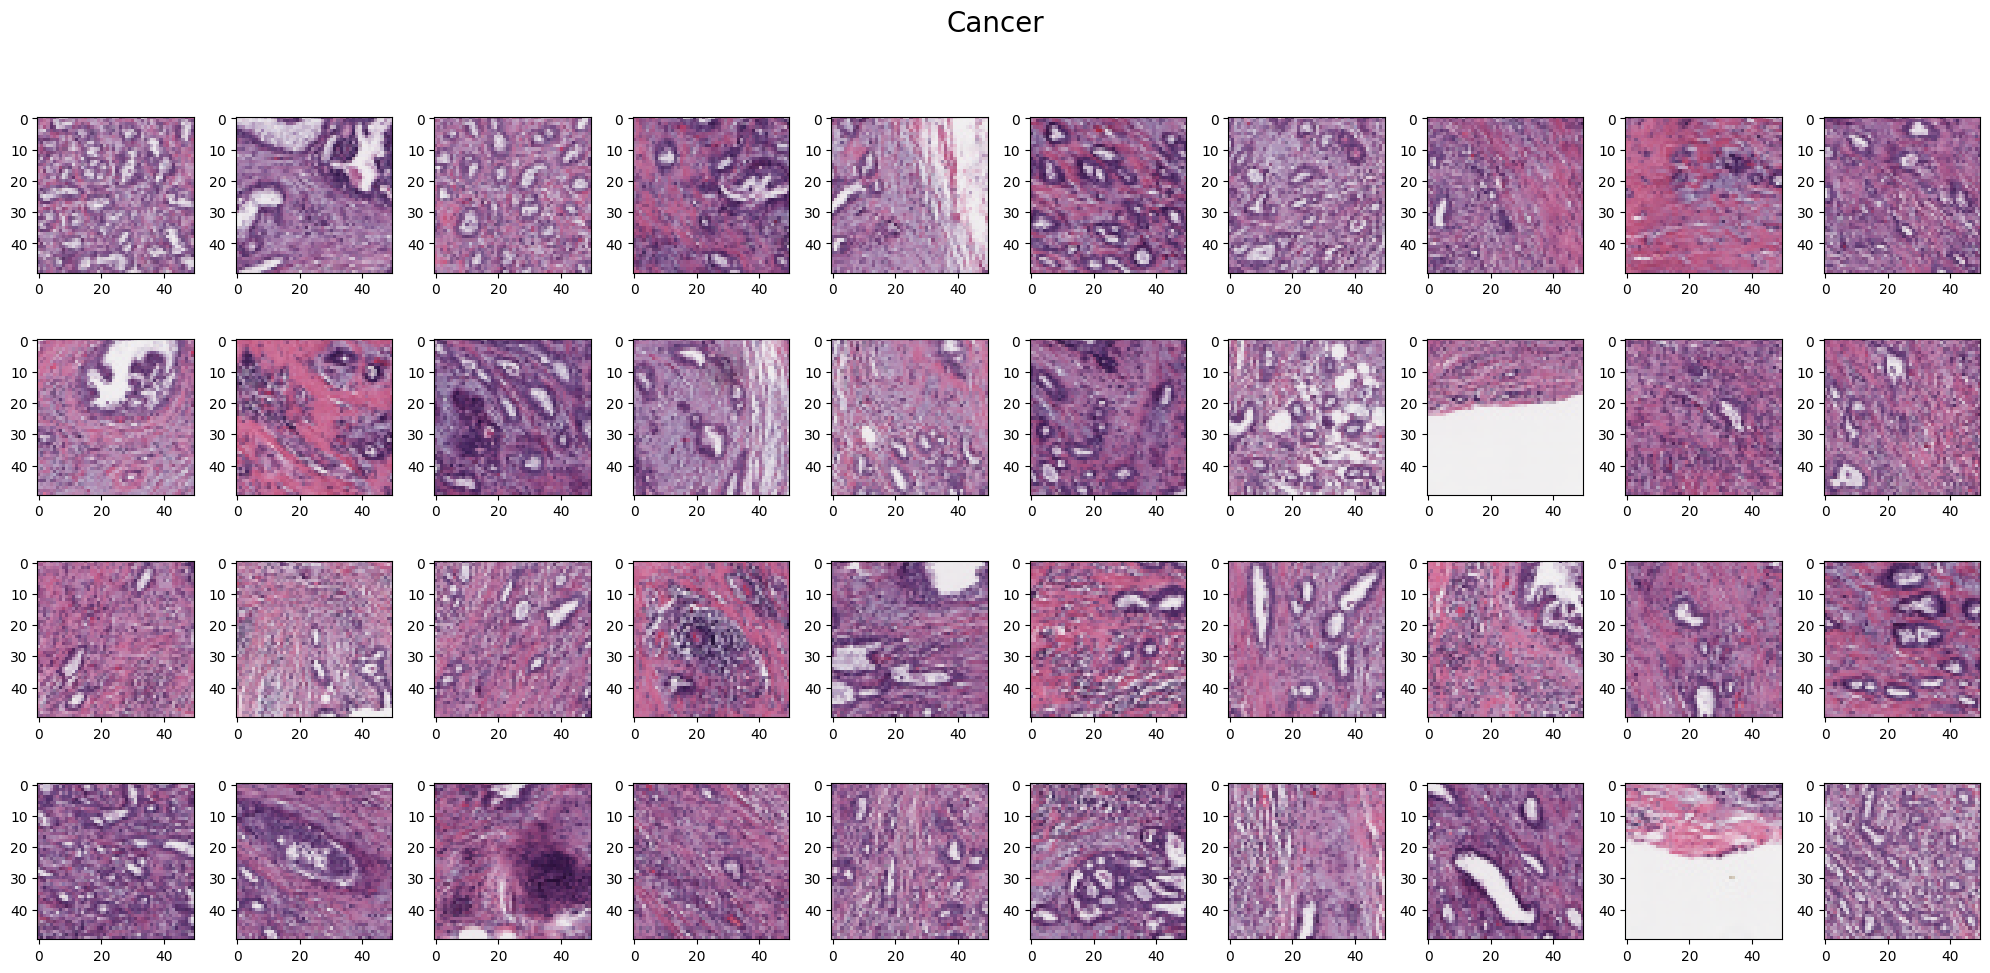

In [ ]:
fig, axes = plt.subplots(4, 10, figsize=(20,10))
fig.suptitle('Cancer', fontsize=20)
for i in range(4):
    for j in range(10):
        image = imread(pos.iloc[j + 10*i]["path"])
        axes[i,j].imshow(image)
plt.tight_layout(rect=[0, 0, 1, 0.96])

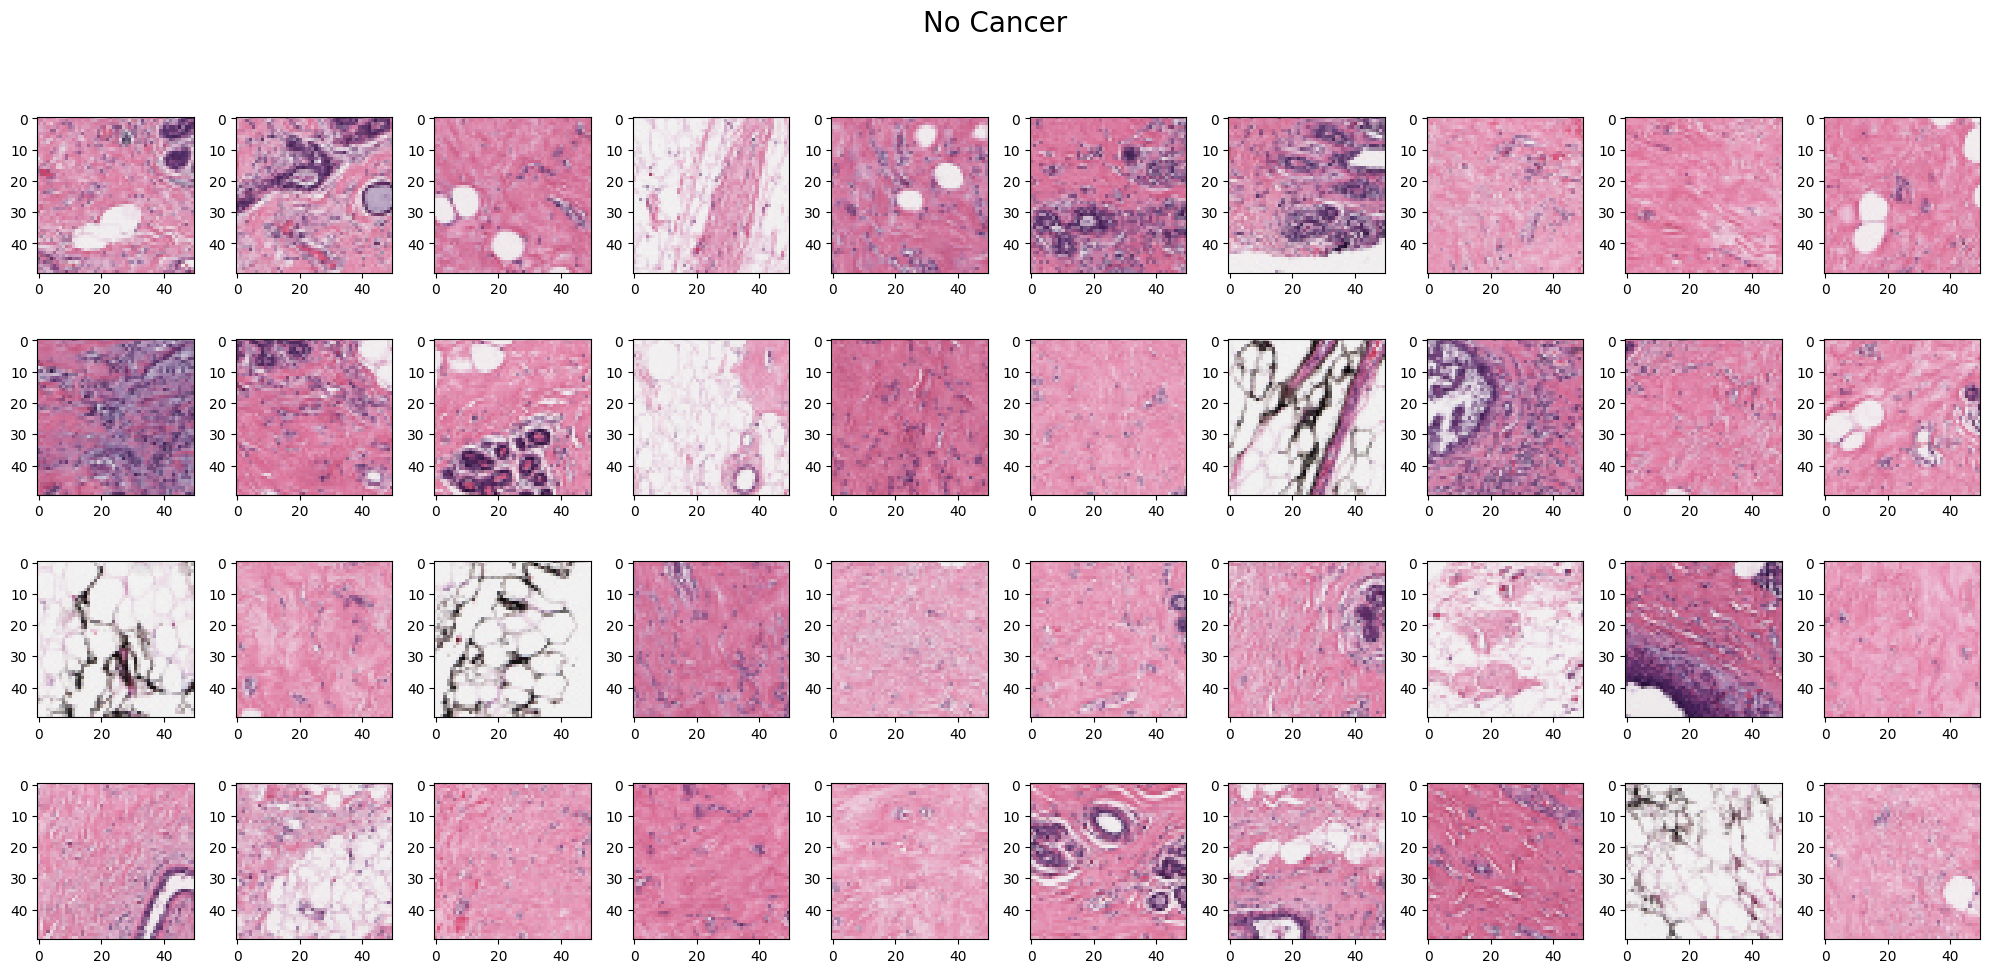

In [ ]:
fig, axes = plt.subplots(4, 10, figsize=(20,10))
fig.suptitle('No Cancer', fontsize=20)
for i in range(4):
    for j in range(10):
        image = imread(neg.iloc[j + 10*i]["path"])
        axes[i,j].imshow(image)
plt.tight_layout(rect=[0, 0, 1, 0.96])

<ipython-input-12-7168ed2606c2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['target'].value_counts().index, y = df['target'].value_counts(), palette='Set1')


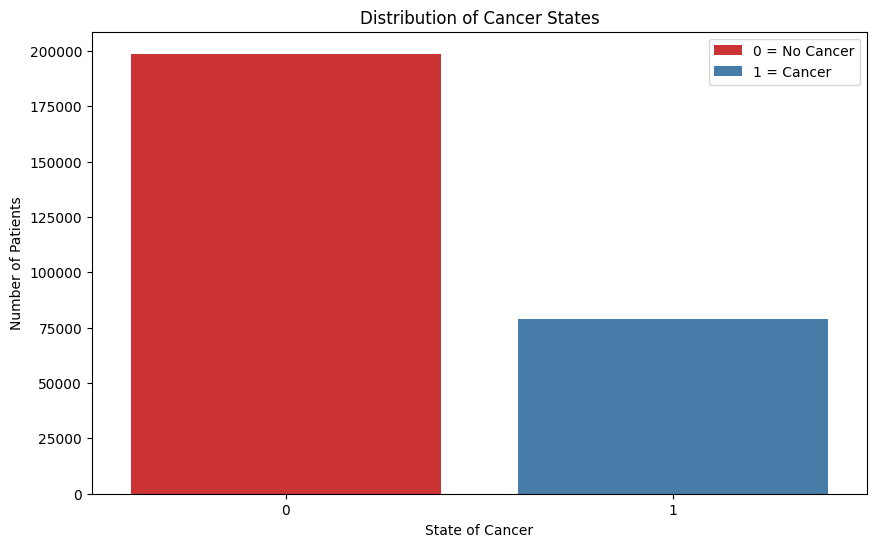

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=df['target'].value_counts().index, y = df['target'].value_counts(), palette='Set1')
plt.xlabel('State of Cancer')
plt.ylabel('Number of Patients')
plt.title('Distribution of Cancer States')
plt.legend(handles=ax.patches[:2], labels=['0 = No Cancer', '1 = Cancer'], loc='upper right')
plt.show()

In [ ]:
from sklearn.utils import resample
pos_balanced = resample(pos,replace=True, n_samples=135000)

In [ ]:
df_balanced = pd.concat([neg, pos_balanced])

In [ ]:
df_balanced.to_csv('balanced_dataframe.csv', index=False)

In [ ]:
df_balanced

,path,target
275,/content/breast-histopathology-images/IDC_regu...,0
276,/content/breast-histopathology-images/IDC_regu...,0
277,/content/breast-histopathology-images/IDC_regu...,0
278,/content/breast-histopathology-images/IDC_regu...,0
279,/content/breast-histopathology-images/IDC_regu...,0
...,...,...
220203,/content/breast-histopathology-images/IDC_regu...,1
71989,/content/breast-histopathology-images/IDC_regu...,1
155278,/content/breast-histopathology-images/IDC_regu...,1
14737,/content/breast-histopathology-images/IDC_regu...,1


In [ ]:
values = df_balanced.values
np.random.shuffle(values)

In [ ]:
X = []
y = []
for feature, label in values:
    image = cv2.imread(feature, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (50, 50), interpolation = cv2.INTER_LINEAR)
    X.append(image)
    y.append(label)
X = np.array(X)
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
print(f'Length of Training Data: {len(X_train)}')
print(f'Length of Testing Data: {len(X_test)}')

Length of Training Data: 266990
Length of Testing Data: 66748


In [ ]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.0001)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 50, 50, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 50, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 25, 25, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,519,298 (9.61 MB)

 Trainable params: 2,518,850 (9.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=64, callbacks=[early_stopping, lr_reduction])

Epoch 1/30
4172/4172 ━━━━━━━━━━━━━━━━━━━━ 49s 9ms/step - accuracy: 0.7588 - loss: 0.6049 - val_accuracy: 0.8066 - val_loss: 0.4699 - learning_rate: 0.0010
Epoch 2/30
4172/4172 ━━━━━━━━━━━━━━━━━━━━ 70s 8ms/step - accuracy: 0.8105 - loss: 0.4391 - val_accuracy: 0.7995 - val_loss: 0.4578 - learning_rate: 0.0010
Epoch 3/30
4172/4172 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.8211 - loss: 0.4142 - val_accuracy: 0.7943 - val_loss: 0.4334 - learning_rate: 0.0010
Epoch 4/30
4172/4172 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 0.8305 - loss: 0.3924 - val_accuracy: 0.7781 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 5/30
4172/4172 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.8414 - loss: 0.3696 - val_accuracy: 0.8321 - val_loss: 0.3962 - learning_rate: 0.0010
Epoch 6/30
4172/4172 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 0.8544 - loss: 0.3443 - val_accuracy: 0.8414 - val_loss: 0.3713 - learning_rate: 0.0010
Epoch 7/30
4172/4172 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.8

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
print("Loss:", loss)

2086/2086 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8998 - loss: 0.4526
Test Accuracy: 0.8991430401802063
Loss: 0.4544413983821869


In [ ]:
y_pred = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

2086/2086 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.91     39749
           1       0.85      0.91      0.88     26999

    accuracy                           0.90     66748
   macro avg       0.89      0.90      0.90     66748
weighted avg       0.90      0.90      0.90     66748



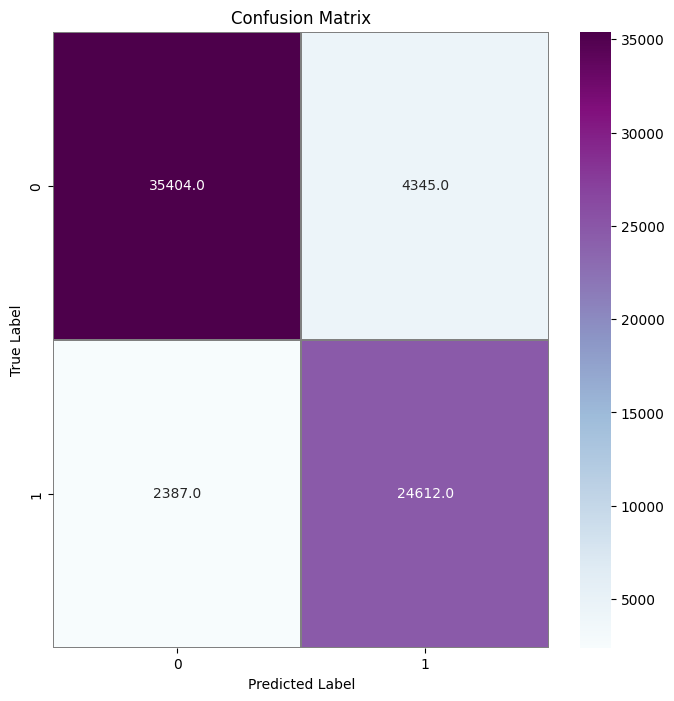

In [ ]:
confusion_mtx = confusion_matrix(y_test, y_pred_classes)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

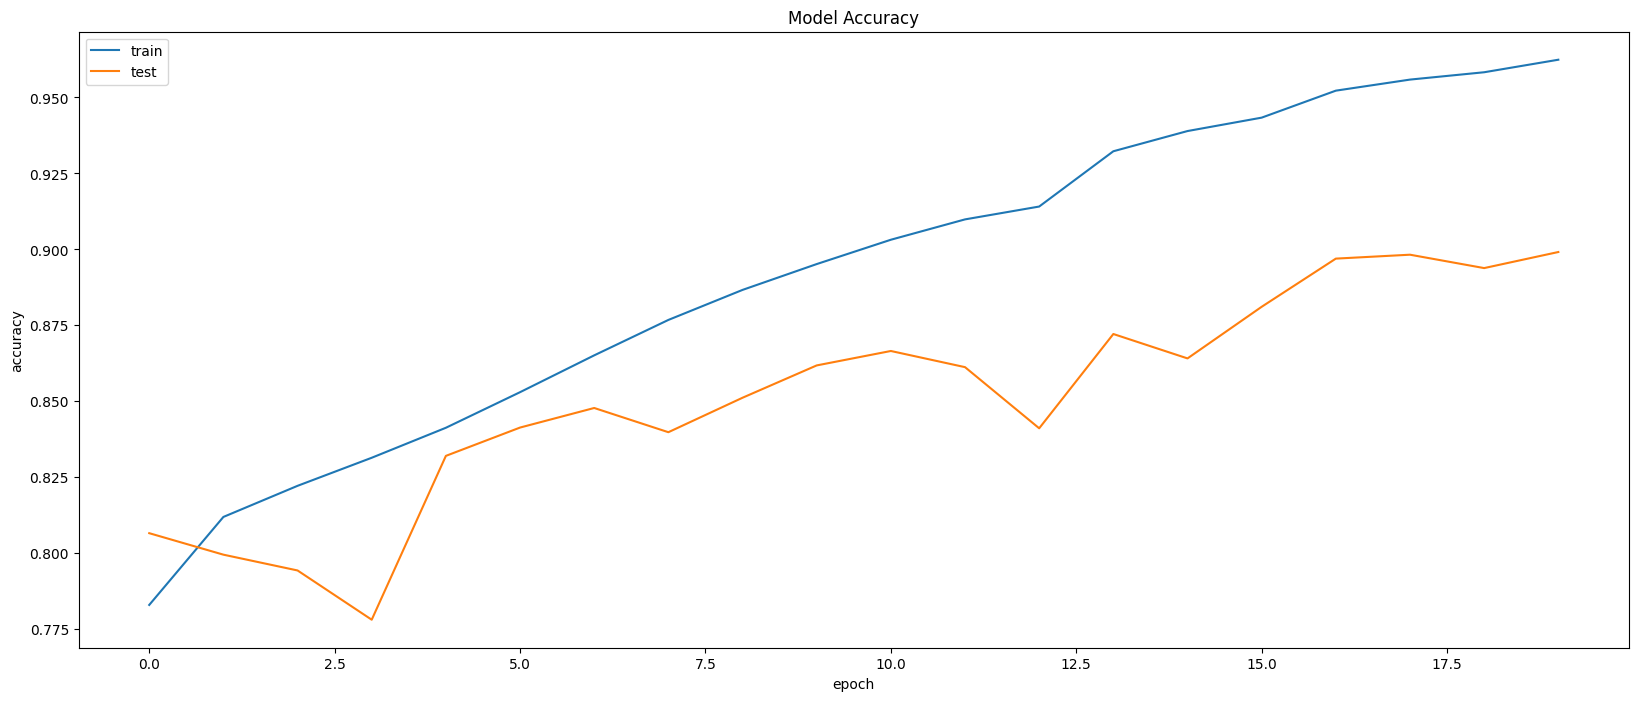

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

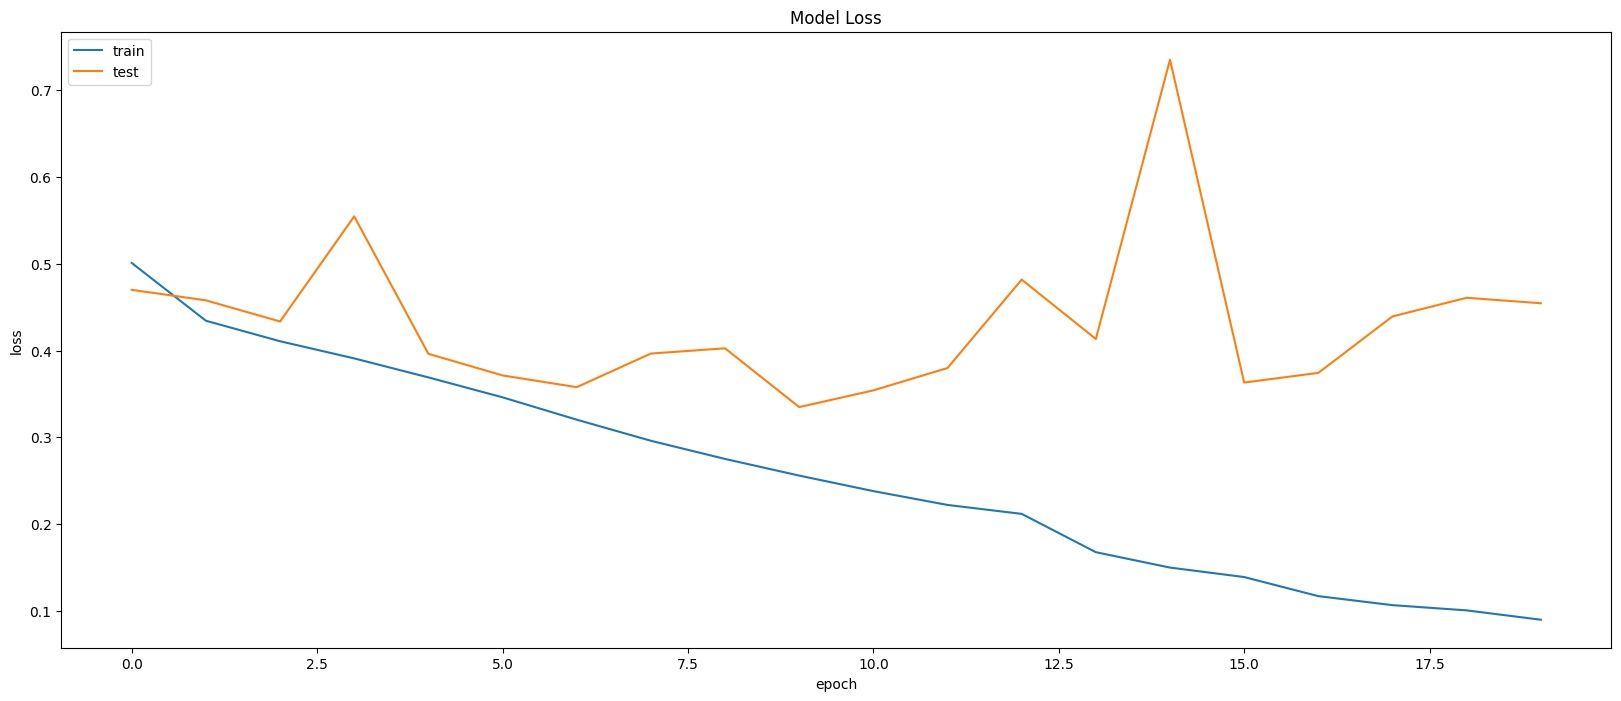

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import save_model
model.save('breast_cancer_model.h5')